# Anslysis of Worldwideimporters Database #
## Emmanuel Olaluyi ##

In [1]:
# importing Python libaries

from sqlalchemy import create_engine        #pip install SQLAlchemy
from sqlalchemy.engine import URL
import pypyodbc as odbc         # pip install pypyodbc
import pandas as pd             # pip install pandas
import matplotlib.pyplot as plt        # pip install matplotlib
import numpy as np              # pip install numpy
import seaborn as sns           # pip install seaborn
from scipy.interpolate import make_interp_spline # pip install scipy

In [2]:
# Establishing connection to database using SQLalchemy
SERVER_NAME = 'LAPTOP-IR5SOTC1'
DATABASE_NAME ='WideWorldImporters'
connection_string = f"""
Driver={{SQL Server}};
Server={SERVER_NAME};
Database={DATABASE_NAME};
Trusted_Connection=yes;
"""
# using ODBC connection for SQLAlchemy (pandas read_sql_query method)

connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url, module=odbc)

## Names of Customers from Sales.Custumer Table ##

In [3]:
# storing sql comment in a variable so pandas can read it
# This query retrieves the names of all custumers from the sales.customers table
sql_query = """
SELECT
    CustomerName
FROM
    Sales.Customers
"""
# calling read_sql function which takes two arguments. pandas to read query and connect to database using Pyodbc library
# The results of the query is stored in the dataframe (df) named customer_name
customer_name = pd.read_sql(sql_query, engine)
# call customer name to view the results of the query in df 
customer_name

,customername
0,Tailspin Toys (Head Office)
1,"Tailspin Toys (Sylvanite, MT)"
2,"Tailspin Toys (Peeples Valley, AZ)"
3,"Tailspin Toys (Medicine Lodge, KS)"
4,"Tailspin Toys (Gasport, NY)"
...,...
658,Ganesh Majumdar
659,Jaroslav Fisar
660,Jibek Juniskyzy
661,Anand Mudaliyar


# Number of orders per customer #

In [4]:
# SQL statment to find: Number of orders made by each customer
sql_query = """
SELECT 
    SC.CustomerName,
    COUNT(OrderDate) AS [Number of Orders]
FROM
    Sales.Customers AS SC
JOIN
    Sales.Orders AS SO
ON
    SC.CustomerID = SO.CustomerID
GROUP BY
    SC.CustomerName
"""
# calling read_sql function which takes two arguments. pandas to read query and connect to database using Pyodbc library
Orders = pd.read_sql(sql_query, engine)
# call the df 
Orders

,customername,number of orders
0,Tailspin Toys (Head Office),129
1,"Tailspin Toys (Sylvanite, MT)",123
2,"Tailspin Toys (Peeples Valley, AZ)",132
3,"Tailspin Toys (Medicine Lodge, KS)",107
4,"Tailspin Toys (Gasport, NY)",121
...,...,...
658,Ganesh Majumdar,19
659,Jaroslav Fisar,14
660,Jibek Juniskyzy,8
661,Anand Mudaliyar,4


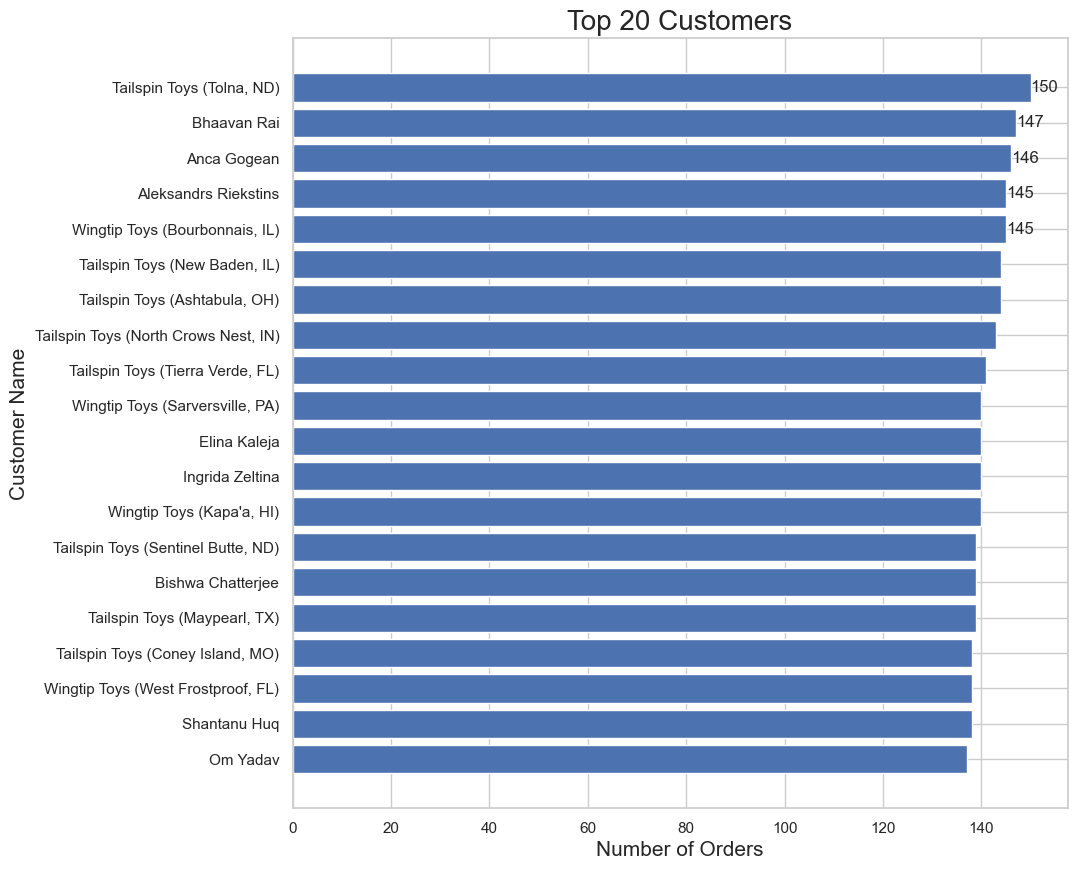

In [5]:
# sorting the number of orders in orders df from highest to lowest
Orders = Orders.sort_values(by='number of orders', ascending=False)
# reversing the order of the df using [::-1] so when ploting the horizontal bar graph the highest value is at the top
Orders = Orders.head(20).iloc[::-1]
# since df has been reversed, use .tail to get top 5 orders and store it in df called top5_order
top5_order = Orders.tail(5) 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,10))
# plot horizontal bar graph
plt.barh(Orders['customername'], Orders['number of orders'])
# zip is used to itterate over customername and number of orders to display the values of the bars on the graph
for i, values in zip(top5_order['customername'], top5_order['number of orders']):
    plt.text(values, i, str(values), ha='left', va='center')

plt.ylabel('Customer Name', size=15)
plt.xlabel('Number of Orders', size=15)
plt.title('Top 20 Customers', size=20)
plt.show()

Here I will do some manipulation on the DataFrame. Since There are two major organizations in the data 'Tailspin Toys' and 'Wingtip Toys' I will group these organizations together as they make up the majority of the data and orders.

In [6]:
# this line replaces the  parentheses any thing inside and replaces it with ''
Orders.customername = Orders.customername.str.replace(r'\(.*\)', '', regex=True) 
# now we can group the custumer name, sum the number of orders and reset the index of the df
grouped_Orders = Orders.groupby('customername')['number of orders'].sum().reset_index() 
grouped_Orders


,customername,number of orders
0,Aleksandrs Riekstins,145
1,Anca Gogean,146
2,Bhaavan Rai,147
3,Bishwa Chatterjee,139
4,Elina Kaleja,140
5,Ingrida Zeltina,140
6,Om Yadav,137
7,Shantanu Huq,138
8,Tailspin Toys,1138
9,Wingtip Toys,563


In [7]:
grouped_Orders = grouped_Orders.sort_values(by='number of orders', ascending=False)
grouped_Orders

,customername,number of orders
8,Tailspin Toys,1138
9,Wingtip Toys,563
2,Bhaavan Rai,147
1,Anca Gogean,146
0,Aleksandrs Riekstins,145
4,Elina Kaleja,140
5,Ingrida Zeltina,140
3,Bishwa Chatterjee,139
7,Shantanu Huq,138
6,Om Yadav,137


Sorted the resulting DataFrame in Descending order.
As you can see TailPin Toys as an organization have the most orders with a total of 1138 Order folowed bt WingSpin Toys. 

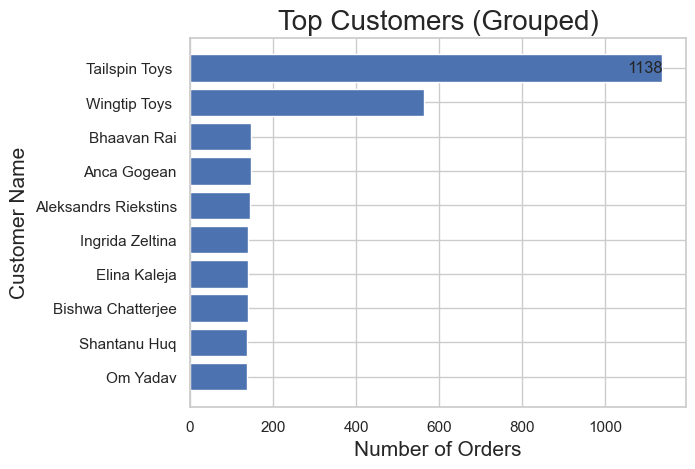

In [8]:
grouped_Orders = grouped_Orders.sort_values(by='number of orders', ascending=True)
Top_grouped = grouped_Orders.tail(1)
plt.barh(grouped_Orders['customername'], grouped_Orders['number of orders'],)
for i, values in zip(Top_grouped['customername'], Top_grouped['number of orders']):
    plt.text(values, i, str(values), ha='right', va='center')
plt.ylabel('Customer Name', size=15)
plt.xlabel('Number of Orders', size=15)
plt.title('Top Customers (Grouped)', size=20)
plt.show()

Identifying your top customers can maximize a company's profits. These customers often contribute disproportionately to a company's revenue, and understanding their preferences can help maximize profits through strategic pricing and product offerings. Additionally you can you use this opportunity to strengthen customer loyalty by offering personalized discounts, promotions or loyalty programs to your high-value customers. 

## I dentifying Top 5 most frequently ordered products ##

In [9]:
sql_query = """
SELECT TOP 5
    Description AS [Product],
    sum(Quantity) AS [Total]
from
        Sales.OrderLines
group by
    Description
Order by
    Total DESC
"""
# calling read_sql function which takes two arguments. pandas to read query and connect to database using Pyodbc library
products = pd.read_sql(sql_query, engine)
# call the df 
products

,product,total
0,Black and orange fragile despatch tape 48mmx75m,207324
1,Black and orange fragile despatch tape 48mmx100m,193680
2,Clear packaging tape 48mmx75m,158626
3,3 kg Courier post bag (White) 300x190x95mm,152375
4,Shipping carton (Brown) 356x356x279mm,152125


Barplot using seaborn

Text(0.5, 1.0, 'Top 5 frequently ordered products')

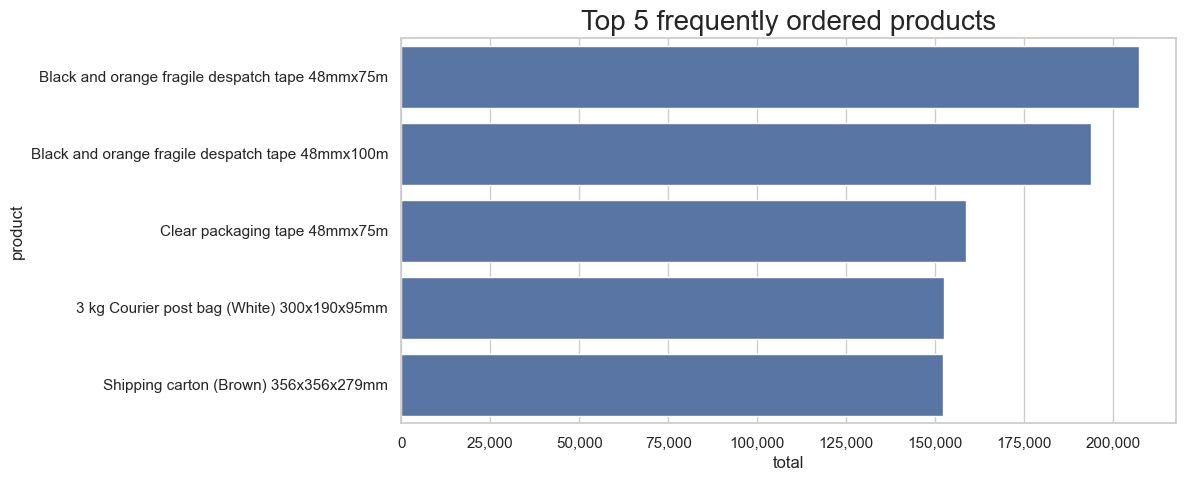

In [10]:
# import FuncFormatter from matplotlib.ticker to format the total along the x axis with ','
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
# seaborn barplot 
sns.barplot(data=products, x="total", y="product" ).xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:,}".format(int(x))))
plt.title('Top 5 frequently ordered products', size= 20)


I dentifying the top performing products can give an insight to what is in demand at the at the moment. Making sure these these type of products stay available can is important to the business and custumer satifaction. Depending on the industry top performing and bottom performers can change quite quickly due to the season or trends that are going on. It is always a good idea to monitor these and react quickly to change.  

## Number of Suppliers per suppliers Category. ##
This information can be foound in the Purchasing.Suppliers & Purchasing.SupplierCategories tables.
Here I join the two table together using the SupplierCategoryID which is a primary key in the Purchasing.SupplierCategories table and the foreign key in the Purchasing.Suppliers


In [11]:
sql_query = """
SELECT
    psc.SupplierCategoryName,
    count(SupplierName) AS [Number of Suppliers]
FROM 
    Purchasing.Suppliers ps
JOIN
    Purchasing.SupplierCategories psc
ON
    ps.SupplierCategoryID = psc.SupplierCategoryID
GROUP BY
     psc.SupplierCategoryName
"""
supply_cat = pd.read_sql(sql_query, engine)
supply_cat

,suppliercategoryname,number of suppliers
0,Novelty Goods Supplier,6
1,Toy Supplier,1
2,Clothing Supplier,1
3,Packaging Supplier,1
4,Courier Services Supplier,1
5,Financial Services Supplier,1
6,Marketing Services Supplier,1
7,Insurance Services Supplier,1


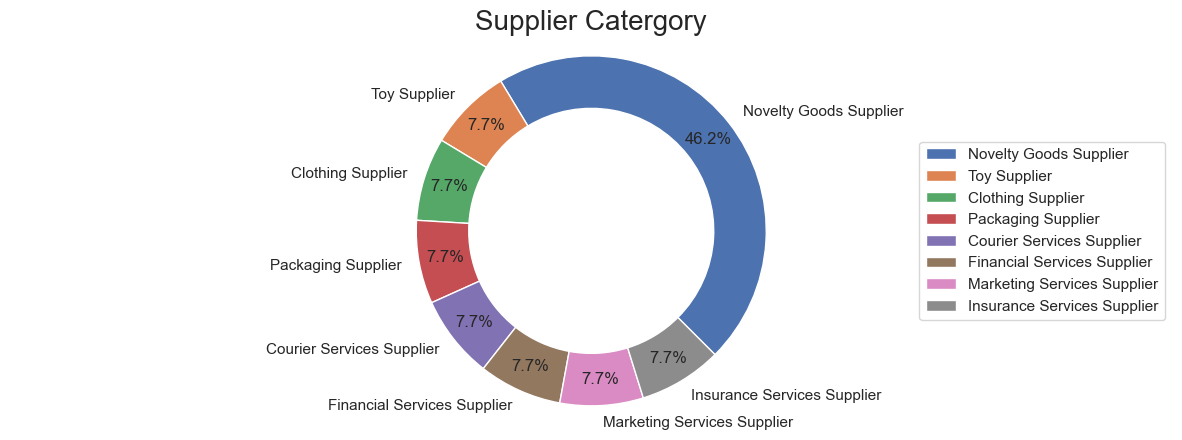

In [12]:
sns.set_theme(style='white') # set the plot theme
plt.figure(figsize=(15,5)) # set the size of the figure 
# use plt.pie to create pie cahrt, I used the wedgeprops argument to create the circle in the middle
# can also use 'plt.circle'  
plt.pie(supply_cat['number of suppliers'], labels= supply_cat['suppliercategoryname'], 
        autopct='%1.1f%%', pctdistance=0.85, startangle=-45, wedgeprops=dict(width=0.3)) 
plt.axis('equal') # making sure the scaling of x & y axis is even
plt.title('Supplier Catergory', size =20)
plt.legend(loc='center right') #adjusting the position of the 
plt.show()

In the above donut plot represents the total numbers of suppliers per category as a percentages. In a business you can easily identify where the majority of your sales will be coming from. But keep in mind that the volume of sales does not always mean that you will have more revenue than the other categories. 

## Top 3 Product sold each month based on revenue ## 

To achieve the results of top 3 products sold each month
This is is a complex query so I created a view to query from.
1. Create a View use CREATE VIEW V_tablename AS (select....)
2. You can also create another view from the first view if you will be needing the same results regularly
I created a CTE instead instead using the With Clause. 
I used the  'ROW_NUMBER()', this function gives all row an interger value begining with 1 and increases by 1 each time
The fuction is combined with OVER (PARTITION BY OrderDate ORDER BY SUM(Revenue) DESC) AS RowNum. 
What this does is that it goes over all the rows and the PARTITION function divides all the rows by each unique date
the result then orders by top 3 products by revenue in descending order (highest - lowest). 
Call this new field RowNum
3. Query the result of the CTE to get the Top 3 Product by month 

In [13]:
sql_query = """
WITH prd3 AS (
    SELECT
        product,
        SUM(Revenue) AS TotalRevenue,
        OrderDate,
        ROW_NUMBER() OVER (PARTITION BY OrderDate ORDER BY SUM(Revenue) DESC) AS RowNum
    FROM
        prd2
    GROUP BY
        OrderDate, product
)

SELECT
    product,
    TotalRevenue,
    OrderDate
FROM
    prd3
WHERE
    RowNum <= 3
"""
Top3_prod = pd.read_sql(sql_query, engine)
Top3_prod

,product,totalrevenue,orderdate
0,32 mm Anti static bubble wrap (Blue) 50m,180600.0,2014-02
1,Air cushion machine (Blue),150021.0,2014-02
2,10 mm Double sided bubble wrap 50m,126000.0,2014-02
3,Air cushion machine (Blue),254466.0,2014-03
4,32 mm Double sided bubble wrap 50m,185920.0,2014-03
...,...,...,...
118,10 mm Anti static bubble wrap (Blue) 50m,255420.0,2015-04
119,32 mm Anti static bubble wrap (Blue) 50m,244650.0,2015-04
120,Air cushion machine (Blue),393093.0,2015-05
121,32 mm Anti static bubble wrap (Blue) 50m,180600.0,2015-05


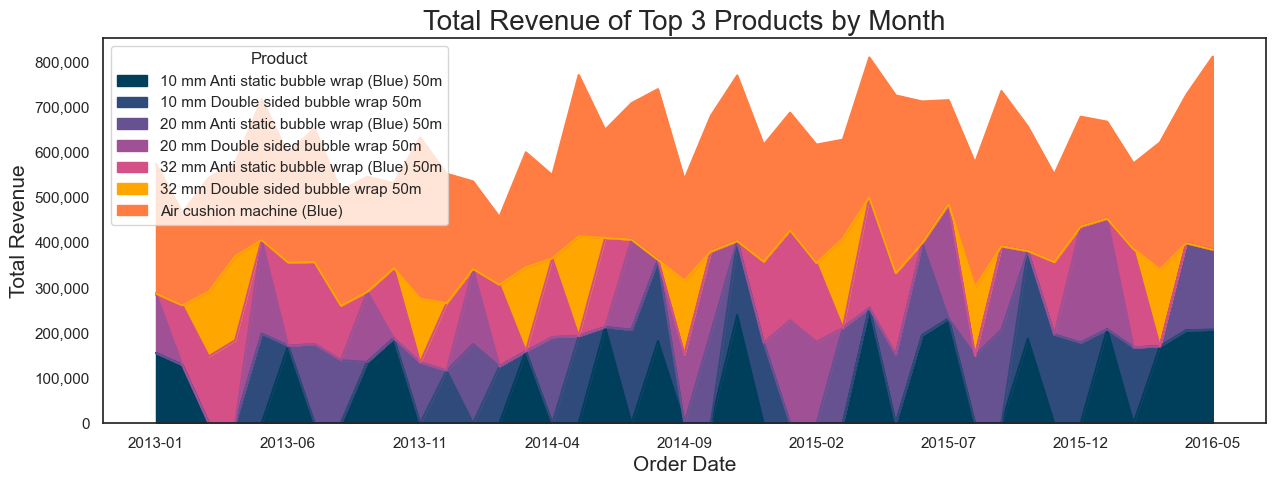

product,10 mm Anti static bubble wrap (Blue) 50m,10 mm Double sided bubble wrap 50m,20 mm Anti static bubble wrap (Blue) 50m,20 mm Double sided bubble wrap 50m,32 mm Anti static bubble wrap (Blue) 50m,32 mm Double sided bubble wrap 50m,Air cushion machine (Blue)
orderdate,,,,,,,
2013-01,155430.0,NaN,NaN,131760.0,NaN,NaN,286749.0
2013-02,128700.0,NaN,NaN,NaN,132300.0,NaN,205092.0
2013-03,NaN,NaN,NaN,NaN,148050.0,143360.0,252567.0
2013-04,NaN,NaN,NaN,NaN,183750.0,185920.0,206991.0
2013-05,NaN,198450.0,NaN,207360.0,NaN,NaN,311436.0
2013-06,171270.0,NaN,NaN,NaN,184800.0,NaN,241173.0
2013-07,NaN,NaN,175440.0,NaN,181650.0,NaN,296244.0
2013-08,NaN,NaN,139740.0,NaN,120750.0,NaN,254466.0
2013-09,135630.0,NaN,NaN,155520.0,NaN,NaN,254466.0


In [14]:
# Pivot function allows eachproduct to become its own column 
pivot_df = Top3_prod.pivot(index='orderdate', columns='product', values='totalrevenue')

# Define custom colors for the countries
custom_colors = ["#003f5c","#2f4b7c","#665191","#a05195","#d45087","#ffa600","#ff7c43"]

# Plot the stacked area chart
pivot_df.plot.area(
    stacked=True, figsize=(15, 5), color=custom_colors
    ).yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:,}".format(int(x))))

plt.title('Total Revenue of Top 3 Products by Month', size =20)
plt.xlabel('Order Date', size=15)
plt.ylabel('Total Revenue', size=15)
plt.legend(title='Product', loc='upper left')

# Show the plot
plt.show()
pivot_df

It's important for a business to know which products sell the most. This helps the business make more money, use its resources better, and keep customers happy. By knowing which products are popular, a business can manage its inventory better and make new products that people will want to buy. Understanding what customers like and what's popular in the market helps a business make smart decisions and stay ahead of the competition

## Total Sales Revenue By Customer Segment ##

In [15]:
sql_query = """
SELECT
    scc.CustomerCategoryName,
    sum(sol.UnitPrice * sol.Quantity) AS revenue
FROM
    Sales.Customers AS sc
JOIN Sales.CustomerCategories AS scc
ON sc.CustomerCategoryID = scc.CustomerCategoryID
JOIN Sales.Orders AS so 
ON sc.CustomerID = so.CustomerID
JOIN
    Sales.Orderlines AS sol
ON sol.OrderID = so.OrderID
Group by scc.CustomerCategoryName
ORDER by revenue DESC
"""

Customerseg_rev = pd.read_sql(sql_query, engine)
Customerseg_rev

,customercategoryname,revenue
0,Novelty Shop,127003996.0
1,Supermarket,14817528.6
2,Gift Store,12036144.9
3,Computer Store,11975987.2
4,Corporate,11800619.7


In [16]:
import plotly.express as px
fig = px.funnel(Customerseg_rev, x=Customerseg_rev['revenue'], y=Customerseg_rev['customercategoryname'])
# Add title and axis title
fig.update_layout(
        title_text='Revenue By custumer Segment',
        title_font=dict(size=20), # adjust title size
        yaxis_title='Revenue',
        font=dict(size=15), # adjust axis title size
        yaxis=dict(
        tickfont=dict(size=14)))
fig.show()


Knowing the customer segment that brings in the most revenue is essential for businesses to optimize their marketing, resource allocation, and decision-making. By focusing on the preferences of high-revenue customers, businesses can improve their advertising, inventory management, sales, and marketing budgets. This knowledge also helps in developing products that align with the needs of valuable customers and in retaining them through personalized services and exclusive offers. Understanding the top-revenue segment gives businesses a competitive edge, aids in financial planning, revenue forecasting, and overall strategic planning for growth.

## Monthly Profit ##

In [17]:
sql_query = """ 
With profit AS (
SELECT
    Format(si.InvoiceDate, 'yyyy-MM') AS [Date],
    SUM(sil.LineProfit) AS [Profit]
FROM  
    Sales.InvoiceLines AS sil
JOIN 
    Sales.Invoices as si
ON sil.InvoiceID = si.InvoiceID
GROUP BY
    si.InvoiceDate)
 SELECT
    Date,
    SUM(Profit) as [Total Profit]
 FROM
    profit
 GROUP BY 
    Date
ORDER BY
    Date
"""
profits = pd.read_sql(sql_query, engine)
profits

,date,total profit
0,2013-01,1890687.80
1,2013-02,1383023.30
2,2013-03,1933679.05
3,2013-04,2011957.20
4,2013-05,2231604.45
5,2013-06,2003843.25
6,2013-07,2177622.75
7,2013-08,1735165.70
8,2013-09,1893782.75
9,2013-10,1882507.65


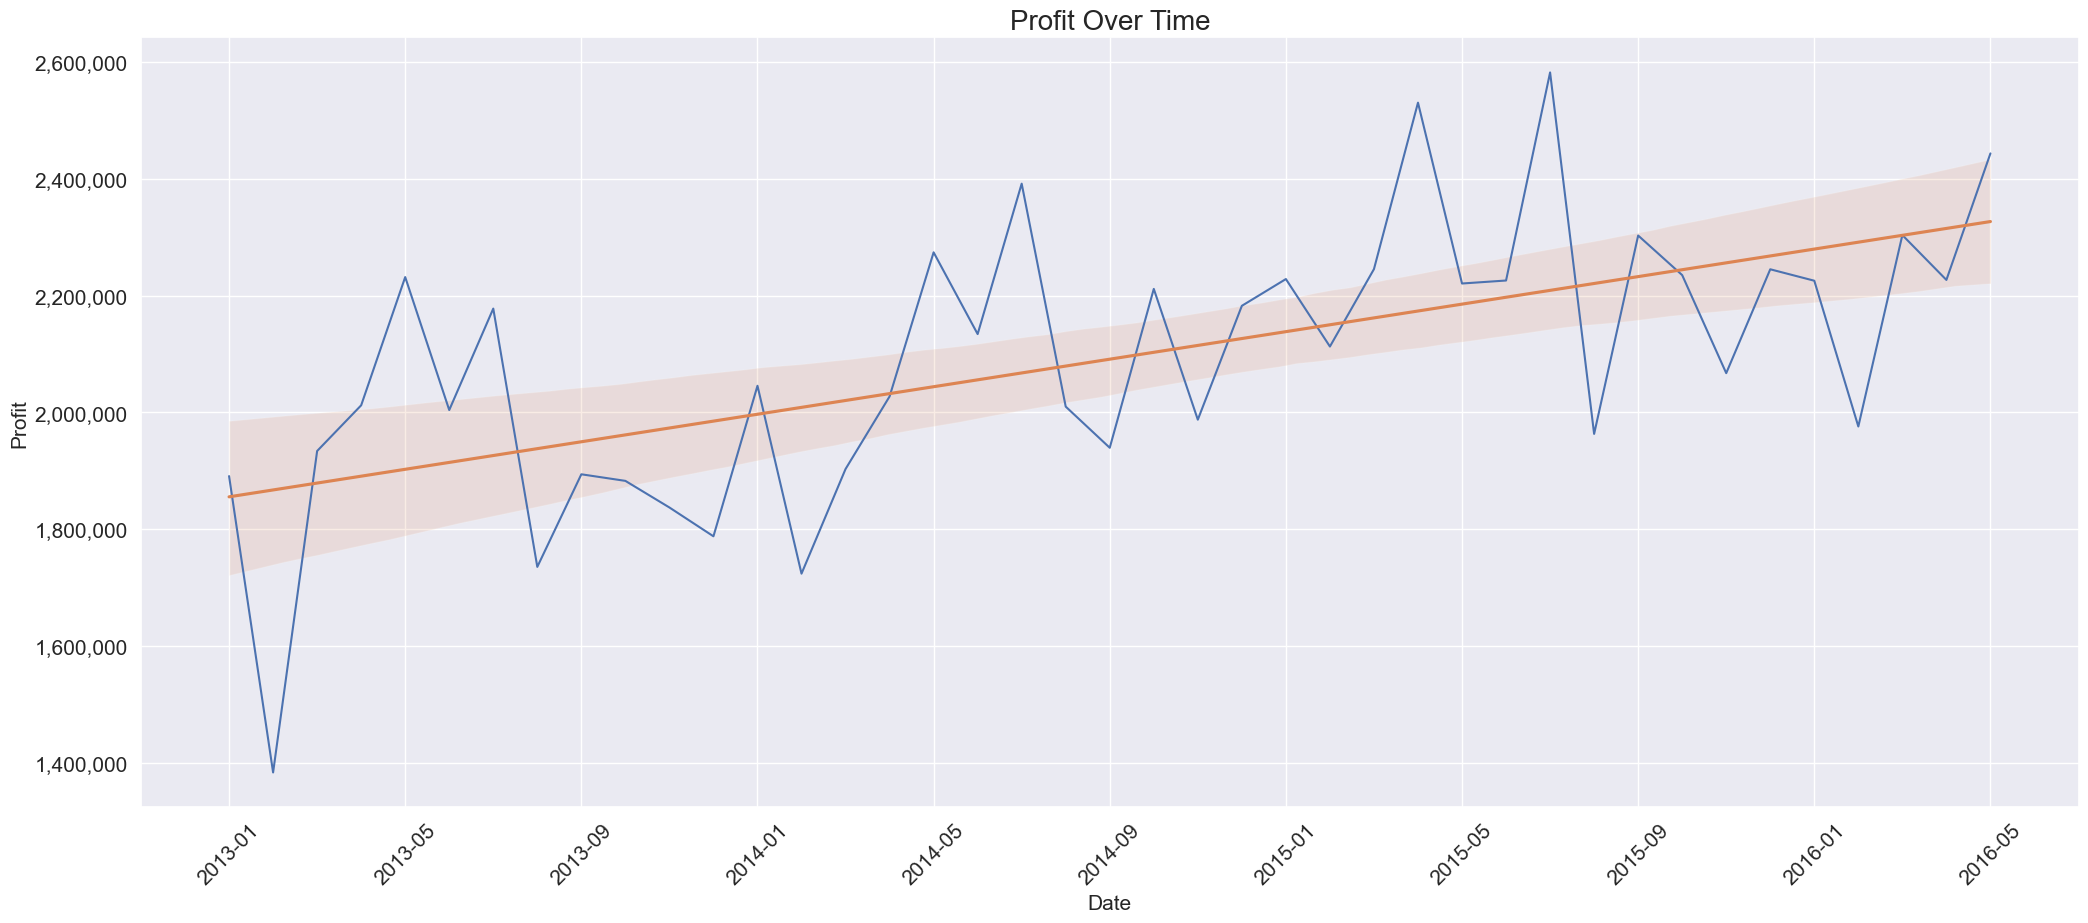

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,10))
sns.lineplot(data=profits, x=profits.date, y='total profit').yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:,}".format(int(x))))
# Trendline
sns.regplot(data=profits, x=profits.index, y='total profit', scatter=False)
n = 4
plt.xticks(profits.date[::n], rotation=45, size=15)
plt.yticks(size=15)
plt.title('Profit Over Time',  size=20)
plt.xlabel('Date', size=15)
plt.ylabel('Profit', size=15)
plt.show()

The Company's profit has a possitive correlation. Overall they are increasing their profits year on year. Profits are crucial for businesses to survive and grow. It allows them to make investments, expand their offerings, and remain competitive. Profitability also helps them repay debts, access capital, and attract talent. A profitable business creates jobs and supports local economies. Overall, making a profit is essential for a business's success, sustainability, and community impact.

## Sales Trend ##

In [19]:
sql_query = """ 
WITH season_sales AS 
(SELECT
    si.InvoiceDate,
    (sil.Quantity * sil.Unitprice) AS [Revenue]
FROM  
    Sales.Invoices AS si
JOIN 
    Sales.InvoiceLines AS sil
ON si.InvoiceID = sil.InvoiceID)
Select 
    FORMAT(InvoiceDate, 'MM') AS [Month],
    SUM(CASE WHEN YEAR(InvoiceDate) = 2013 Then Revenue END) AS [Total Revenue 2013],
    SUM(CASE WHEN YEAR(InvoiceDate) = 2014 Then Revenue END) AS [Total Revenue 2014],
    SUM(CASE WHEN YEAR(InvoiceDate) = 2015 Then Revenue END) AS [Total Revenue 2015],
    SUM(CASE WHEN YEAR(InvoiceDate) = 2016 Then Revenue END) AS [Total Revenue 2016]
FROM season_sales
GROUP BY FORMAT(InvoiceDate,'MM')
ORDER BY MIN(InvoiceDate)
"""
sales = pd.read_sql(sql_query, engine)
# mapping months to the corresponding numbers
sales['month'] = sales['month'].map({
    '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun',
    '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'})
sales

,month,total revenue 2013,total revenue 2014,total revenue 2015,total revenue 2016
0,Jan,3770410.85,4067538.00,4401699.25,4447705.95
1,Feb,2776786.20,3470209.20,4195319.25,4005616.85
2,Mar,3870505.30,3861928.75,4528131.65,4645254.00
3,Apr,4059606.85,4095234.65,5073264.75,4563666.10
4,May,4417965.55,4590639.10,4480730.55,4970932.65
5,Jun,4069036.20,4266644.10,4515840.45,NaN
6,Jul,4381767.45,4786301.05,5155672.00,NaN
7,Aug,3495991.00,4085489.60,3938163.40,NaN
8,Sep,3779040.85,3882968.85,4662600.00,NaN
9,Oct,3752608.45,4438683.65,4492049.40,NaN


Text(0.5, 0, 'Month')

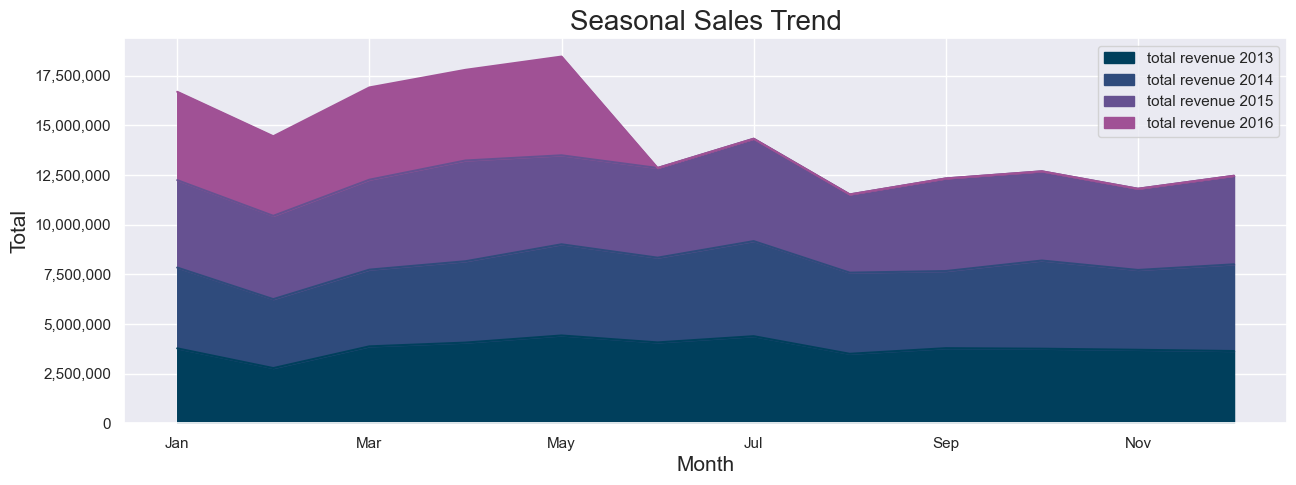

In [20]:
sales.plot.area(
    x= 'month', stacked=True, figsize=(15, 5), color=custom_colors
    ).yaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:,}".format(int(x))))
plt.title('Seasonal Sales Trend', size= 20)
plt.ylabel('Total', size=15)
plt.xlabel('Month', size=15)

Analyzing sales trends year after year is crucial for businesses. It enables them to evaluate their performance comprehensively, identify growth or decline patterns, and uncover insights into market dynamics and customer behavior. Examining seasonal fluctuations can aid in strategic planning and resource allocation. Historical data serves as a basis for forecasting future sales. Furthermore, year-on-year analysis enhances operational efficiency, facilitates risk management, and fosters investor confidence by showcasing a consistent growth trajectory. Ultimately, this approach empowers businesses to make informed decisions, adapt strategies to evolving market conditions, and position themselves for sustained success in a competitive landscape.